In [62]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score as cvs
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix, precision_score, recall_score 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC 
import pandas as pd
from pandas import ExcelFile
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import scipy.io as io
from sklearn.model_selection import GridSearchCV as gs
from sklearn.svm import LinearSVR, SVR

In [50]:
xl = pd.ExcelFile("sarp.xlsx")

In [51]:
xl.sheet_names

['sarp']

In [52]:
ds = xl.parse('sarp')

In [53]:
ds.head()

,ID,gender,Age_Enroll,ageasthonset,asthma_status,Baseline_preDrug_FEV1pp,Baseline_preDrug_FVCpp,Baseline_preDrug_FEV1_FVC,status_factorized
0,1,2,22.753425,7,mild,97,137.0,0.622000,1
1,2,1,25.726027,6,mild,94,100.0,0.770197,1
2,3,2,21.893151,11,mild,114,114.0,0.885287,1
3,4,1,39.827397,27,mild,100,105.0,0.761993,1
4,5,1,20.098630,15,mild,80,93.0,0.727473,1


*******************  Support Vector Machines  ************************

In [63]:
lin_svr = LinearSVR(epsilon=0.5)
pol_svr = SVR(kernel="rbf", degree=2, C=100, epsilon=0.1)
svm_clf = Pipeline([("scaler", StandardScaler()),
                   ("linear_svc", LinearSVC(C=1, loss="hinge"))])
polynomial_svm_clf = Pipeline([("poly_features", PolynomialFeatures(degree=3)), 
                               ("scaler", StandardScaler()), 
                               ("poly_clf", LinearSVC(C=10, loss="hinge"))])
kernel_svm_clf = Pipeline([("scaler", StandardScaler()), 
                                ("kernel_clf", SVC(kernel="rbf", degree=3, coef0=1, C=5))]) 

In [64]:
X_uncleaned = ds.loc[:, "Baseline_preDrug_FEV1pp":"Baseline_preDrug_FEV1_FVC"]
imputer = Imputer(strategy="median")
imputer.fit(X_uncleaned)
X_cleaned = imputer.transform(X_uncleaned)
#print(np.isnan(X_cleaned.any()))
X = pd.DataFrame(X_cleaned, columns=X_uncleaned.columns).astype(np.float64)
#Xds.to_excel("cleaned.xlsx")
#Xmat = X.as_matrix()
#Xmatf = Xmat.astype(np.float64)
X.shape

(1358, 3)

In [65]:
y = ds.loc[:,"ageasthonset"].astype(np.float64)
#ymat = y.as_matrix()
#ymatf = ymat.astype(np.float64)
#isinstance(ymat[0], np.float64)
y.shape

(1358,)

In [66]:
lin_svr.fit(X,y)

LinearSVR(C=1.0, dual=True, epsilon=0.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [71]:
lin_svr.predict([[97, 137, .62]])

array([ 20.62637405])

In [69]:
#scores = cvs(svm_clf, X, y, scoring="neg_mean_squared_error", cv=10)
scores = cvs(lin_svr, X, y, scoring="neg_mean_squared_error", cv=10)
svm_scores = np.sqrt(-scores)

In [72]:
pol_svr.fit(X,y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [75]:
pol_svr.predict([[80, 93, .727]])

array([ 12.34519753])

In [76]:
scores = cvs(pol_svr, X, y, scoring="neg_mean_squared_error", cv=10)
svm_scores = np.sqrt(-scores)

In [77]:
svm_scores

array([ 18.68337483,  17.67251317,  17.00257519,  16.20574574,
        16.6031925 ,  16.18440633,  15.07354729,  16.0242746 ,
        19.92457428,  14.97707167])

In [78]:
svm_scores.mean()

16.835127560175444

In [79]:
y.mean()

13.132547864506627

In [80]:
svm_scores.std()

1.4756803547408559

In [81]:
#st = ds['asthma_status']       
#st.shape

In [82]:
#status, status_cats = st.factorize()
#status

In [83]:
stds = ds['status_factorized'].astype(np.int64)

In [84]:
stds.shape

(1358,)

In [106]:
X2 = X
X2 = X["Baseline_preDrug_FEV1_FVC"]
X2 = pd.DataFrame(X2)

In [107]:
X2 = X2.join(y)

In [108]:
X2 = X2.join(ds["gender"])

In [109]:
X2.shape

(1358, 3)

In [118]:
y2 = stds
y2 = y2.values.ravel()
y2pd = pd.DataFrame(y2)

In [111]:
X2pd = X2
X2 = pd.DataFrame.as_matrix(X2)

In [112]:
pol_svr.fit(X2,y2)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [113]:
def show_class(output):
    if output == 1:
        print("Mild asthma")
    elif output == 2:
        print("Moderate asthma")
    else:
        print("Severe asthma")

In [119]:
res = pol_svr.predict([[.65, 45, 2]]).astype(np.int32)
show_class(res[0])

Moderate asthma


In [120]:
scores = cvs(pol_svr, X2, y2, scoring="neg_mean_squared_error", cv=2)
svm_scores = np.sqrt(-scores)

In [121]:
svm_scores

array([ 0.92491107,  0.91400888])

In [125]:
y_pred = pol_svr.predict(X2).astype(np.int32)
y_pred.shape

(1358,)

In [128]:
f1(y2,y_pred,average='micro')

0.41899852724594994

In [129]:
y_pred

array([2, 1, 1, ..., 1, 2, 1])

In [130]:
y2.shape

(1358,)

In [131]:
confusion_matrix(y2, y_pred)

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  1,  59, 359,  81,   1],
       [  0,   5, 117, 147,   6],
       [  0,   8, 154, 357,  63]], dtype=int64)

In [132]:
precision_score(y2, y_pred, average='micro')

0.41899852724594994

In [133]:
recall_score(y2, y_pred, average='micro')

0.41899852724594994

In [35]:
polynomial_svm_clf.fit(X2, y2)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('poly_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [36]:
res = polynomial_svm_clf.predict([[.65, 45, 1]])
show_class(res[0])

Severe asthma


In [37]:
y_pred = polynomial_svm_clf.predict(X2)
y_pred.shape

(1358,)

In [38]:
f1(y2,y_pred,average='micro')

0.59646539027982326

In [39]:
confusion_matrix(y2, y_pred)

array([[428,   0,  73],
       [100,   0, 175],
       [200,   0, 382]], dtype=int64)

In [43]:
kernel_svm_clf.fit(X2, y2)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kernel_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [44]:
res = kernel_svm_clf.predict([[.65, 45, 1]])
show_class(res[0])

Severe asthma


In [45]:
y_pred = kernel_svm_clf.predict(X2)
y_pred.shape

(1358,)

In [46]:
kernel_svm_clf.classes_

array([1, 2, 3], dtype=int64)

In [47]:
f1(y2,y_pred,average='micro')

0.60235640648011779

In [48]:
confusion_matrix(y2, y_pred)

array([[409,   0,  92],
       [ 93,   1, 181],
       [174,   0, 408]], dtype=int64)

*******************  K nearest neighbors  ************************

In [146]:
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.neighbors import KNeighborsRegressor as knr
knn_clf = Pipeline([("scaler", StandardScaler()),
                    ("knc", knc(weights='distance', n_jobs=3, n_neighbors=12))])
knn_reg = knr(weights='distance', n_jobs=3, n_neighbors=12)

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33)

In [148]:
knn_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knc', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=3, n_neighbors=12, p=2,
           weights='distance'))])

In [149]:
res = knn_clf.predict([[.72, 15, 1]])
show_class(res[0])

Mild asthma


In [150]:
knn_clf.classes_

array([1, 2, 3], dtype=int64)

In [151]:
y_pred = knn_clf.predict(X_test)
y_pred.shape

(449,)

In [152]:
f1(y_test,y_pred,average='micro')

0.53897550111358572

In [153]:
confusion_matrix(y_test, y_pred)

array([[109,  12,  45],
       [ 26,  14,  51],
       [ 45,  28, 119]], dtype=int64)

In [154]:
len(y_pred[y_pred==2])

54

In [155]:
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=3, n_neighbors=12, p=2,
          weights='distance')

In [156]:
res = knn_reg.predict([[.72, 15, 1]])
show_class(res[0])

Severe asthma


In [158]:
y_pred = knn_reg.predict(X_test)
y_pred.shape

(449,)

*******************  Random forests  ************************

In [163]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
rfc_clf = RandomForestClassifier( n_estimators = 500, max_leaf_nodes = 16, n_jobs =-1) 

In [78]:
rfc_clf.fit(X2, y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [79]:
res = rfc_clf.predict([[.65, 45, 1]])
show_class(res[0])

Severe asthma


In [80]:
rfc_clf.classes_

array([1, 2, 3], dtype=int64)

In [81]:
y_pred = rfc_clf.predict(X2)
y_pred.shape

(1358,)

In [82]:
f1(y2,y_pred,average='micro')

0.6251840942562592

In [78]:
confusion_matrix(y2, y_pred)

array([[415,   6,  80],
       [ 85,  17, 173],
       [166,   3, 413]], dtype=int64)

In [79]:
len(y_pred[y_pred==2])

26

*******************  Ada boosting  ************************

In [80]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(rfc_clf)

In [81]:
ada_clf.fit(X2, y2)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [82]:
res = ada_clf.predict([[.65, 45, 1]])
show_class(res[0])

Severe asthma


In [83]:
y_pred = ada_clf.predict(X2)
y_pred.shape

(1358,)

In [84]:
f1(y2,y_pred,average='micro')

0.88291605301914577

In [85]:
confusion_matrix(y2, y_pred)

array([[483,   0,  18],
       [  6, 201,  68],
       [ 56,  11, 515]], dtype=int64)

In [86]:
len(y_pred[y_pred==-1])

0

***********************  bagging ***************************

In [87]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(knc(), 
                            n_estimators = 200, max_samples = 1358, 
                            bootstrap = True, n_jobs =-1) 

In [88]:
bag_clf.fit(X2, y2)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1358, n_estimators=200, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [89]:
res = bag_clf.predict([[.65, 45, 1]])
show_class(res[0])

Severe asthma


In [90]:
y_pred = bag_clf.predict(X2)
y_pred.shape

(1358,)

In [91]:
f1(y2,y_pred,average='micro')

0.69734904270986742

In [92]:
confusion_matrix(y2, y_pred)

array([[383,  24,  94],
       [ 58, 112, 105],
       [ 92,  38, 452]], dtype=int64)

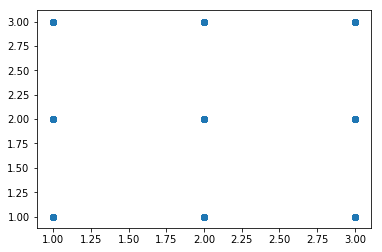

In [93]:
%matplotlib inline
plt.scatter(x=y2, y=y_pred)  

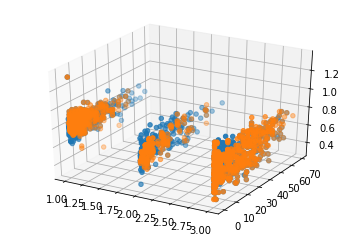

In [94]:
pl = plt.figure().gca(projection='3d')
pl.scatter(y2pd, X2pd['ageasthonset'], X2pd['Baseline_preDrug_FEV1_FVC'])
pl.scatter(y_pred, X2pd['ageasthonset'], X2pd['Baseline_preDrug_FEV1_FVC'])

************************** Grid Search **********************

In [97]:
#param_grid = [ {'kernel_clf__kernel': ["poly", "rbf"], 'kernel_clf__degree': [3, 4, 5, 6], 
#                'kernel_clf__coef0': [0.5, 1, 1.5], 'kernel_clf__C': [1, 2, 3, 4, 5]} ]
#grid_search = gs(kernel_svm_clf, param_grid, cv=5, scoring='neg_mean_squared_error')
param_grid = [ {'n_jobs': [1, 2, 3, 4, 5], 'n_neighbors': [3, 5, 7, 12]} ]
grid_search = gs(knn_clf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X2, y2)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_jobs': [1, 2, 3, 4, 5], 'n_neighbors': [3, 5, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [98]:
grid_search.best_params_

{'n_jobs': 1, 'n_neighbors': 5}

In [99]:
grid_search.best_estimator_ 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')